In [1]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 400

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])


In [5]:

@config_enumerate
def model_S(rt, cn, num_cells=None, data=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_cells = data.shape[1]

    num_loci = rt.shape[0]

    # controls the consistency of replicating on time
    a = pyro.sample('a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('u', dist.Normal(torch.tensor([500.]), torch.tensor([50.])))

        with pyro.plate('num_loci', num_loci):

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

trace = poutine.trace(model_S).get_trace(rt, cn, num_cells=num_cells)
trace.compute_log_prob()
print(trace.format_shapes())


 Trace Shapes:          
  Param Sites:          
          nb_r         1
 Sample Sites:          
        a dist       1 |
         value       1 |
      log_prob       1 |
num_cells dist         |
         value     170 |
      log_prob         |
        t dist     170 |
         value     170 |
      log_prob     170 |
        u dist     170 |
         value     170 |
      log_prob     170 |
 num_loci dist         |
         value     400 |
      log_prob         |
      rep dist 400 170 |
         value 400 170 |
      log_prob 400 170 |
    reads dist 400 170 |
         value 400 170 |
      log_prob 400 170 |


In [6]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'a': torch.tensor([10.]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(rt, cn, num_cells=num_cells)

t = samples.nodes['t']['value']
a = samples.nodes['a']['value']

t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * t_diff))

rep = samples.nodes['rep']['value']

rep_cn = cn * (1. + rep)

reads = samples.nodes['reads']['value']

# a, t, rt, p_rep, t_diff, rep, rep_cn, reads


/Users/mcphera1/Projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


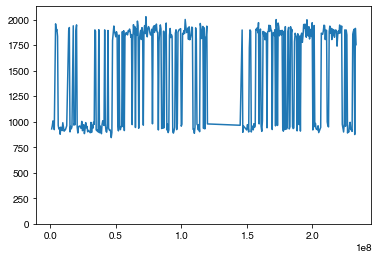

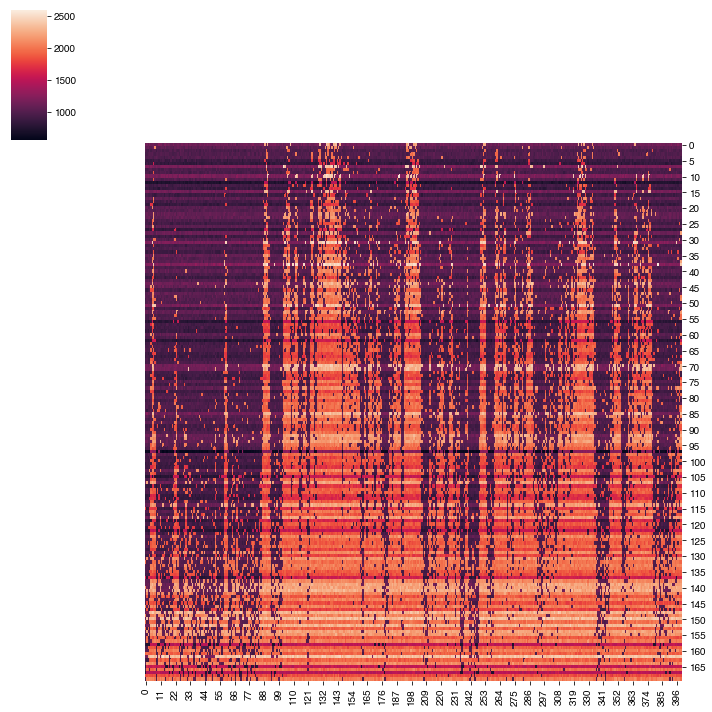

In [7]:

# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)


/Users/mcphera1/Projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


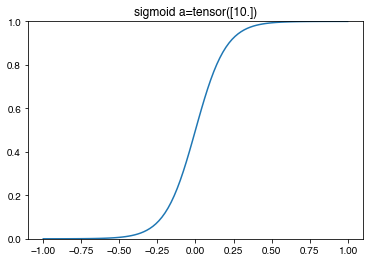

In [8]:

def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['a']['value'].detach())


In [9]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [10]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'nb_r': torch.tensor([10000.0]),
    })

guide = AutoDelta(
    poutine.block(conditioned_model, expose=['a', 'u', 't', 'nb_r'], hide=['rep']),
)
svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [11]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, rt, cn, data=reads)


878882.4108391227

In [12]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(rt, cn, data=reads)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

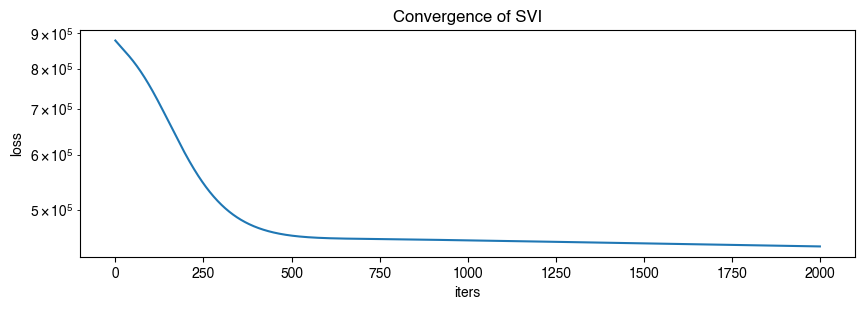

In [13]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.]])

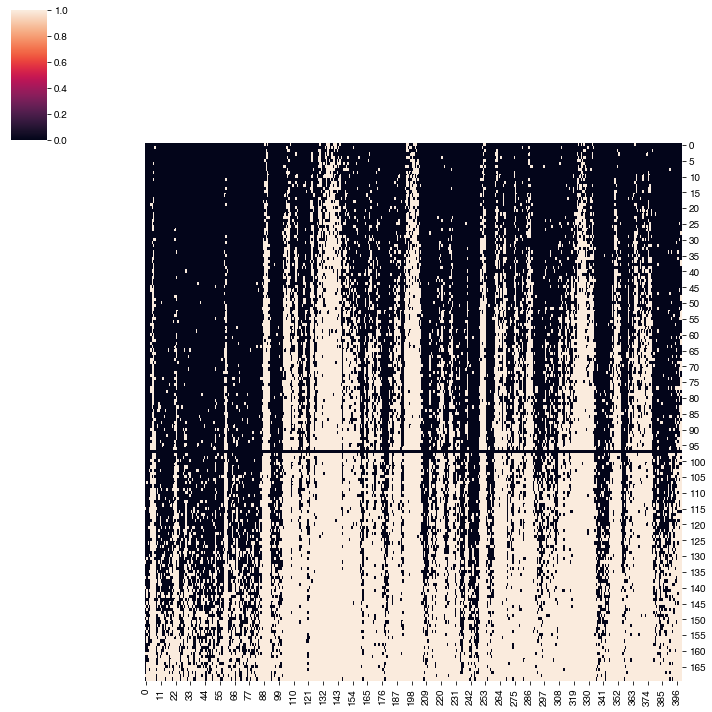

In [14]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(rt, cn, data=reads)
trained_model = poutine.replay(model_S, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(rt, cn, data=reads)

sns.clustermap(trace.nodes["rep"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

trace.nodes["rep"]["value"].numpy()


In [15]:

map_estimates = guide(rt, cn, data=reads)

print(map_estimates['a'].detach().numpy())
print(map_estimates['t'].detach().numpy().round(2))


[10.072791]
[0.46 0.64 0.63 0.89 0.51 0.87 0.58 0.89 0.4  0.55 0.16 0.11 0.99 0.88
 0.26 0.33 0.09 0.43 0.63 0.06 0.51 0.68 0.46 0.24 0.94 0.   0.55 0.13
 0.61 0.98 0.   0.49 0.67 0.84 0.75 0.59 0.19 0.26 0.61 0.8  0.64 0.2
 0.52 0.46 0.84 0.37 0.67 0.45 0.68 1.   0.78 0.44 0.34 0.48 0.66 0.53
 0.09 0.35 0.38 0.74 0.26 0.61 0.73 0.49 0.08 0.03 0.81 0.64 0.27 0.97
 0.61 0.23 0.07 0.49 0.14 0.26 0.7  0.46 0.   0.69 0.48 0.62 0.22 0.24
 0.94 0.9  0.55 0.38 0.79 0.83 0.   0.75 0.78 0.72 0.22 0.64 0.96 0.58
 0.81 0.69 0.36 0.79 0.4  0.5  0.83 0.72 0.52 0.05 0.01 0.43 0.35 0.86
 0.3  0.49 0.89 0.49 0.45 0.05 0.53 0.7  0.86 0.61 0.68 0.97 0.49 0.22
 0.32 0.23 0.16 0.09 0.33 0.45 0.38 0.29 0.71 0.67 0.3  0.97 0.95 0.45
 0.95 0.72 0.89 0.13 0.93 0.32 0.04 0.15 0.03 0.39 0.88 1.   0.77 0.93
 0.8  0.06 0.17 0.2  0.77 0.86 0.43 0.84 0.4  0.14 0.44 0.25 0.09 0.2
 0.31 0.69]


<AxesSubplot:>

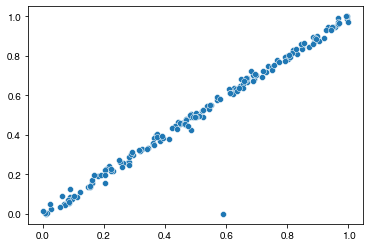

In [16]:

sns.scatterplot(
    x=t,
    y=map_estimates['t'].detach().numpy(),
)


In [17]:
map_estimates

{'a': tensor([10.0728], grad_fn=<ExpandBackward0>),
 't': tensor([4.6267e-01, 6.3534e-01, 6.3289e-01, 8.9476e-01, 5.0667e-01, 8.6912e-01,
         5.7711e-01, 8.9476e-01, 3.9903e-01, 5.4724e-01, 1.5808e-01, 1.1275e-01,
         9.9166e-01, 8.7665e-01, 2.5538e-01, 3.2715e-01, 9.0023e-02, 4.2578e-01,
         6.3051e-01, 5.5048e-02, 5.1178e-01, 6.7990e-01, 4.6267e-01, 2.4260e-01,
         9.4322e-01, 1.1688e-04, 5.4976e-01, 1.2568e-01, 6.1129e-01, 9.8392e-01,
         7.3962e-04, 4.8866e-01, 6.7293e-01, 8.4475e-01, 7.4614e-01, 5.8940e-01,
         1.9164e-01, 2.5853e-01, 6.1371e-01, 8.0051e-01, 6.4477e-01, 1.9521e-01,
         5.2198e-01, 4.6006e-01, 8.4475e-01, 3.6636e-01, 6.6827e-01, 4.5482e-01,
         6.7526e-01, 9.9936e-01, 7.7778e-01, 4.4430e-01, 3.3567e-01, 4.7830e-01,
         6.5656e-01, 5.3213e-01, 8.5274e-02, 3.5251e-01, 3.8278e-01, 7.4386e-01,
         2.6478e-01, 6.1352e-01, 7.2801e-01, 4.8866e-01, 7.5549e-02, 2.6929e-02,
         8.0968e-01, 6.3528e-01, 2.7404e-01, 9.7305e

In [18]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k])


AutoDelta.a tensor([10.0728], grad_fn=<AddBackward0>)
AutoDelta.t tensor([4.6267e-01, 6.3534e-01, 6.3289e-01, 8.9476e-01, 5.0667e-01, 8.6912e-01,
        5.7711e-01, 8.9476e-01, 3.9903e-01, 5.4724e-01, 1.5808e-01, 1.1275e-01,
        9.9166e-01, 8.7665e-01, 2.5538e-01, 3.2715e-01, 9.0023e-02, 4.2578e-01,
        6.3051e-01, 5.5048e-02, 5.1178e-01, 6.7990e-01, 4.6267e-01, 2.4260e-01,
        9.4322e-01, 1.1688e-04, 5.4976e-01, 1.2568e-01, 6.1129e-01, 9.8392e-01,
        7.3962e-04, 4.8866e-01, 6.7293e-01, 8.4475e-01, 7.4614e-01, 5.8940e-01,
        1.9164e-01, 2.5853e-01, 6.1371e-01, 8.0051e-01, 6.4477e-01, 1.9521e-01,
        5.2198e-01, 4.6006e-01, 8.4475e-01, 3.6636e-01, 6.6827e-01, 4.5482e-01,
        6.7526e-01, 9.9936e-01, 7.7778e-01, 4.4430e-01, 3.3567e-01, 4.7830e-01,
        6.5656e-01, 5.3213e-01, 8.5274e-02, 3.5251e-01, 3.8278e-01, 7.4386e-01,
        2.6478e-01, 6.1352e-01, 7.2801e-01, 4.8866e-01, 7.5549e-02, 2.6929e-02,
        8.0968e-01, 6.3528e-01, 2.7404e-01, 9.7305e-01